<h1>Recreating Results of Syracuse Paper</h1>

In [1]:
import sys  
sys.path.insert(1, '../src')

In [2]:
import os
import itertools
import numpy as np
import pandas as pd

from utils import * 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, auc, RocCurveDisplay, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
df = pd.read_csv("../data/transformed/watermain_breaks_train.csv")
val = pd.read_csv("../data/transformed/watermain_breaks_validation.csv")
test = pd.read_csv("../data/transformed/watermain_breaks_test.csv")

<h2>Prepare Data</h2>

2015-2018 is our target period

Outcome: if the pipe will breaks in the next 3 years

In [5]:
#looking from 2015 trying to predict next 3 years
CUTOFF = pd.to_datetime('01-01-2016')
TEST_VAL_CUTOFF = pd.to_datetime('01-01-2019')

In [6]:
df = process_date_cols(df, CUTOFF)

<h3>Downsample majority class</h3>

In [7]:
df['will_break'].value_counts()

will_break
0    19869
1      158
Name: count, dtype: int64

In [8]:
positives = df[df['will_break'] == 0].sample(450, replace = False)
negatives = df[df['will_break'] == 1]

df = pd.concat([positives, negatives])

In [9]:
df['will_break'].value_counts()

will_break
0    450
1    158
Name: count, dtype: int64

In [10]:
cols = ['PressureSy', 'STATUS', 'MATERIAL', 'SUBTYPE']
df = svm_data_transform_pipeline(df, CUTOFF, cols)

In [11]:
val = process_date_cols(val, TEST_VAL_CUTOFF)
val = svm_data_transform_pipeline(val, TEST_VAL_CUTOFF, cols)

test = process_date_cols(test, TEST_VAL_CUTOFF)
test = svm_data_transform_pipeline(test, TEST_VAL_CUTOFF, cols)

<h3>Handling some differences in dummy variables</h3>

In [12]:
all_cols = list(test.columns) 
all_cols.extend(list(df.columns))
all_cols.extend(list(val.columns))

for col in all_cols: 
    if col not in list(test.columns):
        test[col] = 0
    if col not in list(val.columns):
        val[col] = 0
    if col not in list(df.columns):
        df[col] = 0

<h2>Split</h2>

In [13]:
X_train = df.drop(columns = ['will_break'])
y_train = df['will_break']

X_test = test.drop(columns = ['will_break'])
y_test = test['will_break']

X_val = val.drop(columns = ['will_break'])
y_val = val['will_break']

<h2>Scaling</h2>

In [14]:
numeric_cols = list(X_train.columns)
numeric_cols.remove('installation_year')

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])
X_val_scaled = scaler.transform(X_val[numeric_cols])

X_train = np.concatenate([X_train_scaled, np.array(X_train['installation_year'].values).reshape(-1, 1)], axis = 1)
X_test = np.concatenate([X_test_scaled, np.array(X_test['installation_year'].values).reshape(-1, 1)], axis = 1)
X_val = np.concatenate([X_val_scaled, np.array(X_val['installation_year'].values).reshape(-1, 1)], axis = 1)

<h2>Cross Validation</h2>

In [16]:
grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10], 'kernel': ['rbf', 'poly'], 'degree': [3, 4, 5, 6], 
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10], 'class_weight': ['balanced', {0: 0.1, 1: 0.9}, {0:0.25, 1:0.75}]}
keys, values = zip(*grid.items())
combos = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [17]:
cv_scores = []
for combo in combos:
    c = combo['C']
    gamma = combo['gamma']
    class_weight = combo['class_weight']

    clf = SVC(kernel = 'rbf', C = c, gamma = gamma, class_weight = class_weight)
    clf.fit(X_train, y_train)

    pred = clf.predict(X_val)
    score = f1_score(pred, y_val)
    cv_scores.append(score)
        

<h2>Best Config</h2>

In [18]:
best_idx = cv_scores.index(max(cv_scores))
best_idx

846

In [19]:
best = combos[best_idx]

C = best['C']
gamma = best['gamma']
weights = best['class_weight']
kernel = best['kernel']
degree = best['degree']

In [20]:
best

{'C': 5,
 'kernel': 'rbf',
 'degree': 3,
 'gamma': 0.01,
 'class_weight': 'balanced'}

In [21]:
clf = SVC(C = C, class_weight = weights, kernel = kernel, degree = degree)

In [22]:
clf.fit(X_train, y_train)

SVC(C=5, class_weight='balanced')

In [23]:
pred = clf.predict(X_val)

In [24]:
pred = clf.predict(X_val)
print(classification_report(pred, y_val))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88      1131
           1       0.53      0.03      0.06       308

    accuracy                           0.79      1439
   macro avg       0.66      0.51      0.47      1439
weighted avg       0.73      0.79      0.70      1439



In [25]:
f1_score(pred, y_val)

0.06116207951070336

In [26]:
test_pred = clf.predict(X_test)
f1_score(test_pred, y_test)

0.052060737527114966

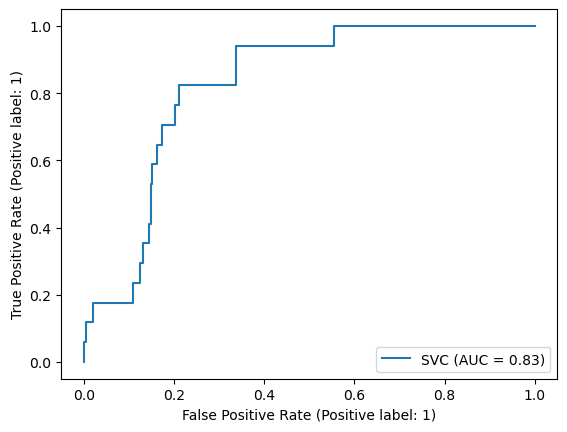

In [27]:
RocCurveDisplay.from_estimator(clf, X_test, y_test)